In [6]:
import pandas as pd

# read in

In [7]:
df = pd.read_csv('../../2_Feature_Engineering/export/combined_polly_bretschneider_iwg.csv')
df.head()

,raw_text,severity,binary_label
0,ist ekelhaft bei ihren Klos kannst du nur mit...,0.0,False
1,Bevor Sie mit Jud...,1.0,True
2,Und de Amis freut es wenn die Heuschrecken Eur...,0.0,False
3,": Die Krim ist ein heißer Tip, auch zum In...",1.0,True
4,: Es muss in #Deutschland eine politische Kra...,1.0,True


# clean

In [8]:
import sys
sys.path.insert(0, r'..\..\0_common')
from model_helpers import clean_all as ci

In [9]:
df['cleaned_text'] = df['raw_text'].apply(ci)
df.head()

,raw_text,severity,binary_label,cleaned_text
0,ist ekelhaft bei ihren Klos kannst du nur mit...,0.0,False,ekelhaft klos kannst gummistiefel gehen stinkt...
1,Bevor Sie mit Jud...,1.0,True,bevor judenstern markiert worden juden ganze ...
2,Und de Amis freut es wenn die Heuschrecken Eur...,0.0,False,de amis freut heuschrecken europa klein wirtsc...
3,": Die Krim ist ein heißer Tip, auch zum In...",1.0,True,krim heißer tip investieren muß bürger landes...
4,: Es muss in #Deutschland eine politische Kra...,1.0,True,deutschland politische kraft geben sozial sch...


In [10]:
df.shape

(9169, 4)

# vectorize

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vec = CountVectorizer(ngram_range=(2,5), analyzer='char_wb', stop_words='german', max_features=100000)

In [13]:
X_features = vec.fit_transform(df['cleaned_text'])

In [15]:
X_features.shape

(9169, 75428)

# main function

In [16]:
def split_train_score(features, labels, clf):
    
    # split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)
    
    #train    
    clf.fit(X_train, y_train)
    
    # score
    from sklearn.metrics import precision_recall_fscore_support as score
    y_pred = clf.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label=True, average='binary')
    
    # confusion matrix
    from sklearn.metrics import confusion_matrix
    matrix = confusion_matrix(y_test, y_pred)
    m_df = pd.DataFrame(
    matrix, 
    columns=["Negatives", "Positives"],
    index=["Negatives", "Positives"])
    
    return fscore, precision, recall, m_df

# Evaluate Function

In [17]:
scores = {}
matrices = {}

In [18]:
def evaluate_algo(key, clf):
    scores[key] = []
    matrices[key] = []

    for i in range(10):
        fscore, precision, recall, confusion_matrix = split_train_score(X_features, df['binary_label'], clf)
        scores[key].append([fscore, precision, recall])
        matrices[key].append(confusion_matrix)

    scores_df = pd.DataFrame(scores[key], columns=['fscore', 'precision', 'recall']) 
    fscore_avg = round(scores_df['fscore'].mean(),3)
    prec_avg = round(scores_df['precision'].mean(),3)
    rec_avg = round(scores_df['recall'].mean(),3)
    
    '''
    print(key.upper())
    print('---')
    print('Fscore: ', fscore_avg)
    print('Min/Max: {} / {} '.format(round(scores_df['fscore'].max(), 3), round(scores_df['fscore'].min(),3)))
    '''
    
    return fscore_avg, prec_avg, rec_avg

# Evaluate

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

algos = {
    'lr': LogisticRegression(),
    'dct': DecisionTreeClassifier(),
    'bnb': BernoulliNB(),
    'mnb': MultinomialNB(),
    'svm': SGDClassifier(),
    'rf': RandomForestClassifier()
}

In [20]:
for i in range(3):    
    results = {}

    for index, clf in algos.items():
        fscore, precision, recall = evaluate_algo(index, clf)
        results[index] = [fscore, precision, recall]

    result_df = pd.DataFrame.from_dict(results, orient = 'index', columns=['fscore', 'precision', 'recall']).sort_values('fscore', ascending=False)
    print(result_df)

C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


     fscore  precision  recall
lr    0.905      0.906   0.905
dct   0.896      0.894   0.899
rf    0.890      0.900   0.881
svm   0.855      0.842   0.872
mnb   0.829      0.815   0.843
bnb   0.777      0.808   0.749


C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


     fscore  precision  recall
lr    0.910      0.919   0.900
dct   0.898      0.897   0.899
rf    0.896      0.907   0.885
svm   0.853      0.852   0.857
mnb   0.827      0.814   0.841
bnb   0.771      0.804   0.740


C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


     fscore  precision  recall
lr    0.907      0.914   0.900
dct   0.901      0.900   0.903
rf    0.894      0.909   0.880
svm   0.850      0.851   0.853
mnb   0.821      0.806   0.837
bnb   0.775      0.809   0.745


# confusion matrix of LR

In [21]:
# winner winner chicken dinner
clf = LogisticRegression()

fscore, precision, recall, m_df = split_train_score(X_features, df['binary_label'], clf)
m_df

C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Negatives,Positives
Negatives,921,72
Positives,84,757


In [22]:
fscore, precision, recall, m_df = split_train_score(X_features, df['binary_label'], clf)
m_df

,Negatives,Positives
Negatives,889,81
Positives,100,764


In [23]:
fscore, precision, recall, m_df = split_train_score(X_features, df['binary_label'], clf)
m_df

,Negatives,Positives
Negatives,869,68
Positives,90,807


# ROC Curve of LR

In [29]:
# winner winner chicken dinner
clf = LogisticRegression()

 # split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, df['binary_label'], test_size=0.2, shuffle=True)
    
#train    
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr, tpr, thresholds)

C:\Users\pascal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.         0.06729758 1.        ] [0.         0.90486976 1.        ] [2 1 0]


In [31]:
%matplotlib inline

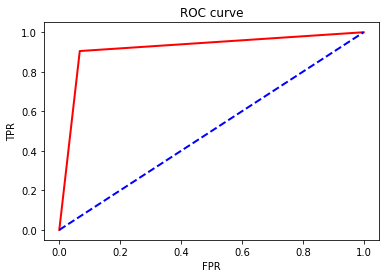

In [32]:
import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()